In [1]:
import numpy as np
from Frame import Frame
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import colors as mcolors
%matplotlib qt


image_path = 'I:/My Drive/Research/gaussian_splatting/gaussian_splatting_input/mov1_2023_08_09_60ms/'
dict_path  = 'I:/My Drive/Research/gaussian_splatting/gaussian_splatting_input/mov1_2023_08_09_60ms/dict/frames_model.pkl'

frame = 370



with open(dict_path,'rb') as f:
    frames = pickle.load(f)

frames = [Frame(image_path,frame,cam,frames_dict = frames) for cam in range(4)] 




In [ ]:
mov_frame = 'mov_59_frame_2016'
mov = int(mov_frame.split('_')[1]) 
frame = int(mov_frame.split('_')[3]) 


path = f'G:/My Drive/Research/gaussian_splatting/gaussian_splatting_input/evaluation/points/mov{mov}/wing1_gt_points_frame{frame}.pkl'
with open(path,'rb') as f:
    ini_angles1 = pickle.load(f)
cam1 = np.vstack(ini_angles1['cam1'])
plt.scatter(cam1[:,0],cam1[:,1])
path = f'G:/My Drive/Research/gaussian_splatting/gaussian_splatting_input/evaluation/points/mov{mov}/wing2_gt_points_frame{frame}.pkl'
with open(path,'rb') as f:
    ini_angles2 = pickle.load(f)
cam1 = np.vstack(ini_angles2['cam1'])
plt.scatter(cam1[:,0],cam1[:,1])

{'cam1': [], 'cam2': [], 'cam3': [], 'cam4': []}

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import colors as mcolors

# %matplotlib qt  # You can uncomment if you want external window

def get_n_colors(n):
    colors = [mcolors.to_rgba(c)
                  for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
    colors = colors * math.ceil(n / len(colors))
    return colors[:n]

def fundamental_matrix(P1, P2, K1, K2):
    R1 = P1[:, 0:3]
    R2 = P2[:, 0:3]
    t1 = P1[:, 3]
    t2 = P2[:, 3]

    R = R2.T @ R1
    t = R1.T @ (t2 - t1)

    tx = np.array([[0, -t[2], t[1]],
                   [t[2], 0, -t[0]],
                   [-t[1], t[0], 0]])
    Y = np.linalg.solve(K2.T, R) @ tx
    F = np.linalg.solve(K1.T, Y.T).T
    return F

def lineToBorderPoints(lines, imageSize):
    nPts = lines.shape[0]
    pts = -np.ones((nPts, 4))
    firstRow = 0.5
    firstCol = 0.5
    lastRow = firstRow + imageSize[0]
    lastCol = firstCol + imageSize[1]
    eps = np.finfo(np.float32).eps

    for iLine in range(nPts):
        a = lines[iLine, 1]
        b = lines[iLine, 0]
        c = lines[iLine, 2]
        endPoints = np.zeros((4))
        iPoint = 0

        if abs(a) > eps:
            row = -(b * firstCol + c) / a
            if firstRow <= row <= lastRow:
                endPoints[iPoint:iPoint+2] = [row, firstCol]
                iPoint += 2
            row = -(b * lastCol + c) / a
            if firstRow <= row <= lastRow:
                endPoints[iPoint:iPoint+2] = [row, lastCol]
                iPoint += 2
        if abs(b) > eps:
            if iPoint < 3:
                col = -(a * firstRow + c) / b
                if firstCol <= col <= lastCol:
                    endPoints[iPoint:iPoint+2] = [firstRow, col]
                    iPoint += 2
            if iPoint < 3:
                col = -(a * lastRow + c) / b
                if firstCol <= col <= lastCol:
                    endPoints[iPoint:iPoint+2] = [lastRow, col]
                    iPoint += 2

        for i in range(iPoint, 4):
            endPoints[i] = -1
        pts[iLine, :] = endPoints[[1, 0, 3, 2]]

    return pts


In [64]:
colors = get_n_colors(80)
import random

rand_idx = random.randint(0, 80)
colors[rand_idx]

(0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)

In [ ]:
import itertools as it
                     
intrinsic = [frames[cam].K for cam in range(4)]
rotation_translation = [np.hstack((frames[cam].R.T,frames[cam].X0)) for cam in range(4)]

all_intrinsic = [(a, b) for a, b in it.product(intrinsic, repeat=2) if a is not b]
all_rotation_translation = [(a, b) for a, b in it.product(rotation_translation, repeat=2) if a is not b]
cam_num = [(a, b) for a, b in it.product(range(4), repeat=2) if a != b]

F = [fundamental_matrix(P1[0], P1[1], K1[0], K1[1]) for P1, K1 in zip(all_rotation_translation, all_intrinsic)]

In [ ]:
dict_cameras = {f'cam{idx + 1}':[] for idx in range(4)}
for idx,cam in enumerate(cam_num):
    cam_from = cam[0]
    cam_to = cam[1]
    dict_cameras[f'cam{cam_from + 1}'].append(F[idx])



{'cam1': [array([[ 7.26675111e-09, -3.95830777e-09, -3.64946880e-05],
         [ 1.30728208e-10, -1.86762410e-10, -9.24332246e-07],
         [ 2.40395143e-05,  3.83897353e-05, -1.41374421e-03]]),
  array([[ 3.80568853e-10,  7.98917496e-09, -3.42222519e-05],
         [-2.69805322e-11, -2.43670225e-10,  1.04546163e-06],
         [-4.44062119e-05, -3.61312316e-07,  6.40229171e-03]]),
  array([[-6.88159861e-09, -3.98338306e-09, -3.60881905e-05],
         [ 1.05705276e-10, -5.38644415e-10, -8.62289873e-07],
         [ 2.34625511e-05, -3.67843287e-05,  4.09280813e-03]])],
 'cam2': [array([[ 7.26675144e-09,  1.30728209e-10,  2.40395143e-05],
         [-3.95830838e-09, -1.86761974e-10,  3.83897378e-05],
         [-3.64946895e-05, -9.24331210e-07, -1.41373825e-03]]),
  array([[-2.15253010e-10,  9.44345845e-09, -3.03902219e-05],
         [ 9.50420845e-09,  3.07010830e-11, -2.89633587e-05],
         [-3.25198310e-05,  2.83632980e-05,  5.51646734e-03]]),
  array([[-1.71164696e-10,  9.70692100e-09,

In [34]:
intrinsic = [frames[cam].K for cam in range(4)]
rotation = [frames[cam].R.T for cam in range(4)]
translation = [frames[cam].X0 for cam in range(4)]
fig, axs = plt.subplots(1, 4)

for idx in range(3):
    cam_from,cam_to = cam_num[idx]

    pixels1 = np.fliplr(frames[cam_from].pixels[:, :])[30:35, :]
    num_points = pixels1.shape[0]
    axs[0].imshow(np.array(frames[cam_from].im))
    axs[cam_to].imshow(np.array(frames[cam_to].im))


    fund = F[cam_to]
    pix_h = np.concatenate([pixels1, np.ones((pixels1.shape[0], 1))], 1)
    epiLines = pix_h @ fund.T
    pts = lineToBorderPoints(epiLines, I2.shape)

    fig.suptitle('Epipolar lines')
    colors = get_n_colors(num_points)
    axs[0].scatter(pixels1[:, 0], pixels1[:, 1], c = colors)
    lines = np.stack([pts[:, :2], pts[:, 2:]], axis=1)
    collection=collections.LineCollection(lines, colors=colors)
    axs[cam_to].add_collection(collection)


plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4)
im_size = [160,160]
from IPython.display import display

for idx in range(3):        
    cam_from,cam_to = cam_num[idx]
    axs[0].imshow(np.array(frames[cam_from].im))
    axs[cam_to].imshow(np.array(frames[cam_to].im))

list_click = []
def on_click(event, F, axs, im_size):
    # Check if the click happened inside the plot
    if event.xdata is None or event.ydata is None:
        return  # Don't do anything if the click was outside the image

    clicked_pixel = np.array([event.xdata, event.ydata])
    print(f"Clicked pixel: {clicked_pixel}")
    list_click.append(clicked_pixel)

    clicked_pixel = np.array([event.xdata, event.ydata])
    print(clicked_pixel)
    for idx in range(3):

        cam_from,cam_to = cam_num[idx]


        num_points = clicked_pixel.shape[0]
        # axs[0].imshow(np.array(frames[cam_from].im))
        # axs[cam_to].imshow(np.array(frames[cam_to].im))

        fund = F[idx]
        pix_h = np.concatenate([clicked_pixel, np.ones((clicked_pixel.shape[0], 1))], 1)
        epiLines = pix_h @ fund.T
        pts = lineToBorderPoints(epiLines, im_size)

        fig.suptitle('Epipolar lines')
        colors = get_n_colors(num_points)
        axs[0].scatter(clicked_pixel[:, 0], clicked_pixel[:, 1], c = colors)
        lines = np.stack([pts[:, :2], pts[:, 2:]], axis=1)
        collection=collections.LineCollection(lines, colors=colors)
        axs[cam_to].add_collection(collection)


fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, F, axs, im_size))

# Show the plot
plt.show()

Clicked pixel: [79.62903226 65.5516129 ]
Clicked pixel: [ 45.5        130.84193548]
Clicked pixel: [119.11290323  68.51935484]
Clicked pixel: [ 83.5        139.74516129]


In [48]:
list_click

[array([33.62903226, 29.93870968]),
 array([33.62903226, 35.87419355]),
 array([36.59677419, 75.93870968]),
 array([41.0483871 , 78.90645161]),
 array([87.0483871 , 77.42258065]),
 array([92.98387097, 62.58387097]),
 array([91.5       , 62.58387097]),
 array([91.5       , 62.58387097]),
 array([108.72580645,  61.1       ]),
 array([108.72580645,  61.1       ]),
 array([122.98387097,  70.00322581]),
 array([122.98387097,  70.00322581]),
 array([122.98387097,  70.00322581])]

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as collections

# Function to handle user click and update epipolar lines
def on_click(event, F, frames, axs, im_size):
    # Check if the click is within the bounds of the first image
    if event.inaxes != axs[0]:
        return

    # Get the pixel coordinates where the user clicked (event.xdata and event.ydata are float coordinates)
    clicked_pixel = np.array([event.xdata, event.ydata])

    # Update pixels1 with the clicked pixel
    pixels1[0] = clicked_pixel  # Update the first pixel, you can modify this to update based on your needs

    # Clear previous lines and points
    axs[0].cla()
    axs[1].cla()

    # Plot the images again
    axs[0].imshow(np.array(frames[cam_from].im))
    axs[1].imshow(np.array(frames[cam_to].im))

    # Compute the epipolar line for the clicked pixel
    pix_h = np.concatenate([clicked_pixel, np.ones(1)])  # homogeneous coordinates
    epiLines = pix_h @ F.T  # Epipolar line in the second image
    pts = lineToBorderPoints(epiLines, im_size)

    # Plot the clicked pixel and epipolar lines
    axs[0].scatter(clicked_pixel[0], clicked_pixel[1], c='red')
    lines = np.stack([pts[:, :2], pts[:, 2:]], axis=1)
    collection = collections.LineCollection(lines, colors='red')
    axs[1].add_collection(collection)

    # Update the title
    fig.suptitle('Epipolar lines for clicked pixel')
    plt.draw()

# Set up your plot and image data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im_size = [160, 160]

# Initial dummy data for `pixels1` (just to get started, can be modified later)
pixels1 = np.array([[0, 0]])  # Array holding clicked pixels (initially set to [0,0])

# Loop through your images and fund matrices
for idx in range(3):
    cam_from, cam_to = cam_num[idx]

    num_points = pixels1.shape[0]
    axs[0].imshow(np.array(frames[cam_from].im))
    axs[cam_to].imshow(np.array(frames[cam_to].im))

    fund = F[idx]
    pix_h = np.concatenate([pixels1, np.ones((pixels1.shape[0], 1))], 1)
    epiLines = pix_h @ fund.T
    pts = lineToBorderPoints(epiLines, im_size)

    fig.suptitle('Epipolar lines')
    colors = get_n_colors(num_points)
    axs[0].scatter(pixels1[:, 0], pixels1[:, 1], c=colors)
    lines = np.stack([pts[:, :2], pts[:, 2:]], axis=1)
    collection = collections.LineCollection(lines, colors=colors)
    axs[cam_to].add_collection(collection)

# Connect the click event handler
fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, F, frames, axs, im_size))

# Show the plot
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2

In [19]:


F = fundamental_matrix(P1, P2, K1, K2)

colors = get_n_colors(100)  # Generate enough colors

fig, axs = plt.subplots(1, 4)
fig.suptitle('Interactive Epipolar Geometry')
axs[0].imshow(I1)
axs[1].imshow(I2)
axs[2].imshow(I3)
axs[3].imshow(I4)

lines_collection = collections.LineCollection([], colors=[])
axs[1].add_collection(lines_collection)

points_scatter = axs[0].scatter([], [], c=[])

clicked_points = []
pix_h = np.array([80, 80, 1.0])
border_pts = [calculate_epi(pix_h,fund) for fund in F]

# Update points in image 1
old_offsets = points_scatter.get_offsets()
new_offsets = np.vstack([old_offsets, (x, y)]) if old_offsets.size else np.array([[x, y]])
points_scatter.set_offsets(new_offsets)
points_scatter.set_color(colors[len(clicked_points) - 1])

# Update epipolar lines in image 2
old_lines = lines_collection.get_segments()
new_line = np.stack([border_pts[0][:, :2], border_pts[0][:, 2:]], axis=1)
all_lines = np.vstack([old_lines, new_line]) if len(old_lines) else new_line
lines_collection.set_segments(all_lines)

# Update colors for lines
old_colors = lines_collection.get_colors()
new_colors = np.vstack([old_colors, colors[len(clicked_points) - 1]]) if len(old_colors) else np.array([colors[len(clicked_points) - 1]])
lines_collection.set_color(new_colors)

fig.canvas.draw()


ValueError: cannot reshape array of size 1 into shape (1,3)

In [ ]:
border_pts

[array([[ 98.81672965,   0.5       ,  94.71487081, 160.5       ]]),
 array([[ 84.08873208,   0.5       ,  88.97089255, 160.5       ]]),
 array([[ 81.89478593,   0.5       ,  78.01171939, 160.5       ]]),
 array([[160.5       ,  15.06367832,  22.1824713 , 160.5       ]]),
 array([[160.5       , 125.63004698,  21.842693  ,   0.5       ]]),
 array([[  0.5       , 156.17920054, 159.75754201,   0.5       ]])]

In [6]:

# ========================== INTERACTION =============================

def onclick(event):
    if event.inaxes == axs[0]:
        x, y = event.xdata, event.ydata
        print(f"Clicked at x={x:.2f}, y={y:.2f} in image 1")

        clicked_points.append((x, y))
        pix_h = np.array([x, y, 1.0])

        # Compute epipolar line
        line = (F @ pix_h).reshape(1, 3)
        

        # Compute border points
        border_pts = lineToBorderPoints(line, I2.shape)

        # Update points in image 1
        old_offsets = points_scatter.get_offsets()
        new_offsets = np.vstack([old_offsets, (x, y)]) if old_offsets.size else np.array([[x, y]])
        points_scatter.set_offsets(new_offsets)
        points_scatter.set_color(colors[len(clicked_points) - 1])

        # Update epipolar lines in image 2
        old_lines = lines_collection.get_segments()
        new_line = np.stack([border_pts[:, :2], border_pts[:, 2:]], axis=1)
        all_lines = np.vstack([old_lines, new_line]) if len(old_lines) else new_line
        lines_collection.set_segments(all_lines)

        # Update colors for lines
        old_colors = lines_collection.get_colors()
        new_colors = np.vstack([old_colors, colors[len(clicked_points) - 1]]) if len(old_colors) else np.array([colors[len(clicked_points) - 1]])
        lines_collection.set_color(new_colors)

        fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()


In [ ]:
import itertools as it

intrinsic = [frames[cam].K for cam in range(4)]
rotation_translation = [np.hstack((frames[cam].R.T,frames[cam].X0)) for cam in range(4)]

all_intrinsic = [(a,b) for a,b in it.combinations(intrinsic, 2)]
all_rotation_translation = [(a,b) for a,b in it.combinations(rotation_translation, 2)]
cam_num = [(a,b) for a,b in it.combinations(list(range(4)), 2)]


F = [fundamental_matrix(P1[0], P1[1], K1[0], K1[1]) for P1,K1 in zip(all_rotation_translation,all_intrinsic)]
print(cam_num)


[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


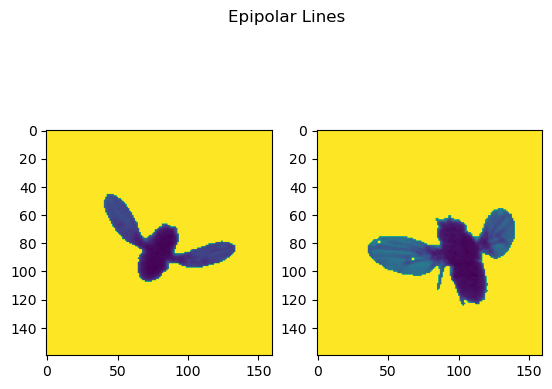

In [16]:
from itertools import permutations
import functools

fig, axs = plt.subplots(1, 2)
fig.suptitle('Epipolar Lines')
axs[0].imshow(frames[0].im)
axs[1].imshow(frames[1].im)
cid = fig.canvas.mpl_connect('button_press_event', functools.partial(onclick, F=F, axs=axs, I1=frames[0].im))

plt.show()


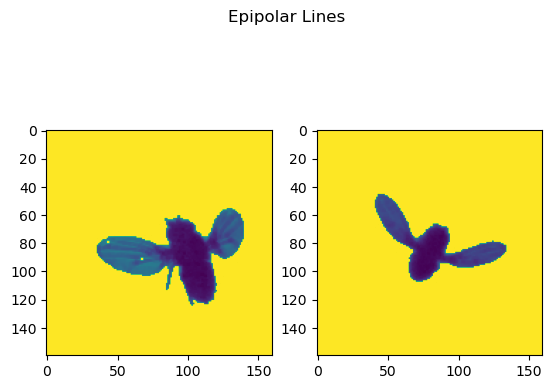

In [42]:

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import colors as mcolors

# ========================== Setup =============================

# Replace this by your actual data:
# intrinsic, rotation, translation, frames

# Example assuming you already have:
# intrinsic = [frames[cam].K for cam in range(4)]
# rotation = [frames[cam].R.T for cam in range(4)]
# translation = [frames[cam].X0 for cam in range(4)]

# Define the images and points


colors = get_n_colors(100)  # Generate enough colors



def onclick(event):
    if event.inaxes == axs[1]:  # Clicked on image 2
        x, y = event.xdata, event.ydata
        print(f"Clicked on Image 2 at x={x:.2f}, y={y:.2f}")
        
        clicked_points_2.append((x, y))

        # Plot the clicked point on image 2
        axs[1].scatter(x, y, color='yellow', zorder=10)
        
        # Compute the epipolar line in the first image
        pix_h = np.array([x, y, 1.0])  # Homogeneous coordinate
        epiLine = F @ pix_h  # F maps points in image2 to lines in image1

        # Find the endpoints of the epipolar line in the first image
        epiLine = epiLine.reshape(1, 3)
        pts_epi = lineToBorderPoints(epiLine, I1.shape)
        line = np.stack([pts_epi[0, :2], pts_epi[0, 2:]], axis=0)

        # Plot the epipolar line in image 1
        line_collection = collections.LineCollection([line], colors='yellow')
        axs[0].add_collection(line_collection)

        # Store the line collection for future removal
        line_collections.append(line_collection)

    elif event.inaxes == axs[0]:  # Clicked on image 1
        x, y = event.xdata, event.ydata
        print(f"Clicked on Image 1 at x={x:.2f}, y={y:.2f}")

        clicked_points_1.append((x, y))

        # Plot the clicked point on image 1
        axs[0].scatter(x, y, color='red', zorder=10)

        # Compute the epipolar line in the second image
        pix_h = np.array([x, y, 1.0])  # Homogeneous coordinate
        epiLine = F.T @ pix_h  # F maps points in image1 to lines in image2

        # Find the endpoints of the epipolar line in the second image
        epiLine = epiLine.reshape(1, 3)
        pts_epi = lineToBorderPoints(epiLine, I2.shape)
        line = np.stack([pts_epi[0, :2], pts_epi[0, 2:]], axis=0)

        # Plot the epipolar line in image 2
        line_collection = collections.LineCollection([line], colors='red')
        axs[1].add_collection(line_collection)

        # Store the line collection for future removal
        line_collections.append(line_collection)

    # Remove previous lines if we exceed a certain number of clicks
    if len(clicked_points_1) + len(clicked_points_2) > 5:
        # Remove old lines to keep the plot clean
        line_collections[0].remove()
        line_collections[1].remove()  # Remove the first two lines
        line_collections = line_collections[2:]  # Update list of stored lines

    # Update the plot
    fig.canvas.draw()

# Define the images and points
intrinsic = [frames[cam].K for cam in range(4)]
rotation = [frames[cam].R.T for cam in range(4)]
translation = [frames[cam].X0 for cam in range(4)]

pixels1 = np.fliplr(frames[1].pixels[:,:])[30:35,:]
pixels2 = frames[0].pixels[0:1,:]
K1 = intrinsic[1]
K2 = intrinsic[0]
P1 = np.hstack((rotation[1], translation[1]))
P2 = np.hstack((rotation[0], translation[0]))

I1 = np.array(frames[1].im)
I2 = np.array(frames[0].im)

# Fundamental matrix calculation
num_points = pixels1.shape[0]
F = fundamental_matrix(P1, P2, K1, K2)

fig, axs = plt.subplots(1, 2)
fig.suptitle('Epipolar Lines')
axs[0].imshow(I1)
axs[1].imshow(I2)

# Connect the callback function for mouse clicks
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Show the plot
plt.show()


In [32]:
clicked_points_1


[(125.82258064516128, 72.8290322580645),
 (109.5, 101.92580645161291),
 (115.72187500000001, 118.1906370967742),
 (98.47604838709677, 153.43210887096774),
 (124.71969758064517, 111.44227016129031)]

In [219]:
K1 = intrinsic[1]
K2 = intrinsic[0]
P1 = np.hstack((rotation[1].T,translation[1]))
P2 = np.hstack((rotation[0].T,translation[0]))
fundamental_matrix(P1, P2, K1, K2)

array([[ 7.26675144e-09,  1.30728209e-10,  2.40395143e-05],
       [-3.95830838e-09, -1.86761974e-10,  3.83897378e-05],
       [-3.64946895e-05, -9.24331210e-07, -1.41373825e-03]])

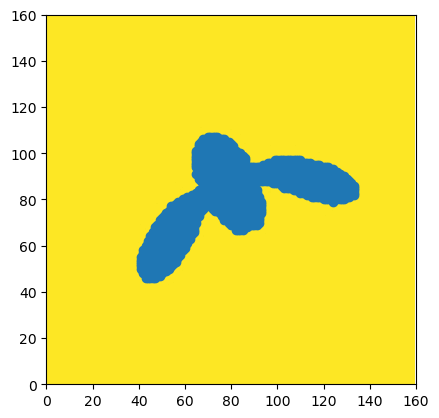

In [211]:
import cv2
import matplotlib.pyplot as plt

img2 = np.array(frames[0].im)

plt.imshow(img2)
plt.plot(y1,x)
plt.scatter(frames[0].pixels[:,1],frames[0].pixels[:,0])
plt.xlim(0,160)
plt.ylim(0,160)

plt.show()

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import colors as mcolors

# Store the drawn lines and points
clicked_points_1 = []
clicked_points_2 = []

# To store line collections, so they can be removed later
line_collections = []

def onclick(event):
    if event.inaxes == axs[1]:  # Clicked on image 2
        x, y = event.xdata, event.ydata
        print(f"Clicked on Image 2 at x={x:.2f}, y={y:.2f}")
        
        clicked_points_2.append((x, y))

        # Plot the clicked point on image 2
        axs[1].scatter(x, y, color='yellow', zorder=10)
        
        # Compute the epipolar line in the first image
        pix_h = np.array([x, y, 1.0])  # Homogeneous coordinate
        epiLine = F @ pix_h  # F maps points in image2 to lines in image1

        # Find the endpoints of the epipolar line in the first image
        epiLine = epiLine.reshape(1, 3)
        pts_epi = lineToBorderPoints(epiLine, I1.shape)
        line = np.stack([pts_epi[0, :2], pts_epi[0, 2:]], axis=0)

        # Plot the epipolar line in image 1
        line_collection = collections.LineCollection([line], colors='yellow')
        axs[0].add_collection(line_collection)

        # Store the line collection for future removal
        line_collections.append(line_collection)

    elif event.inaxes == axs[0]:  # Clicked on image 1
        x, y = event.xdata, event.ydata
        print(f"Clicked on Image 1 at x={x:.2f}, y={y:.2f}")

        clicked_points_1.append((x, y))

        # Plot the clicked point on image 1
        axs[0].scatter(x, y, color='red', zorder=10)

        # Compute the epipolar line in the second image
        pix_h = np.array([x, y, 1.0])  # Homogeneous coordinate
        epiLine = F.T @ pix_h  # F maps points in image1 to lines in image2

        # Find the endpoints of the epipolar line in the second image
        epiLine = epiLine.reshape(1, 3)
        pts_epi = lineToBorderPoints(epiLine, I2.shape)
        line = np.stack([pts_epi[0, :2], pts_epi[0, 2:]], axis=0)

        # Plot the epipolar line in image 2
        line_collection = collections.LineCollection([line], colors='red')
        axs[1].add_collection(line_collection)

        # Store the line collection for future removal
        line_collections.append(line_collection)

    # Remove previous lines if we exceed a certain number of clicks
    if len(clicked_points_1) + len(clicked_points_2) > 5:
        # Remove old lines to keep the plot clean
        line_collections[0].remove()
        line_collections[1].remove()  # Remove the first two lines
        line_collections = line_collections[2:]  # Update list of stored lines

    # Update the plot
    fig.canvas.draw()

# Define the images and points
intrinsic = [frames[cam].K for cam in range(4)]
rotation = [frames[cam].R.T for cam in range(4)]
translation = [frames[cam].X0 for cam in range(4)]

pixels1 = np.fliplr(frames[1].pixels[:,:])[30:35,:]
pixels2 = frames[0].pixels[0:1,:]
K1 = intrinsic[1]
K2 = intrinsic[0]
P1 = np.hstack((rotation[1], translation[1]))
P2 = np.hstack((rotation[0], translation[0]))

I1 = np.array(frames[1].im)
I2 = np.array(frames[0].im)

# Fundamental matrix calculation
num_points = pixels1.shape[0]
F = fundamental_matrix(P1, P2, K1, K2)

fig, axs = plt.subplots(1, 2)
fig.suptitle('Epipolar Lines')
axs[0].imshow(I1)
axs[1].imshow(I2)

# Connect the callback function for mouse clicks
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Show the plot
plt.show()


In [25]:
clicked_points

[(113.37096774193546, 68.57096774193548),
 (50.919354838709666, 25.99032258064514),
 (23.951612903225765, 94.11935483870968),
 (116.91935483870961, 128.89354838709676)]

In [214]:
a, b, c = epipolars[200]  # unpack line coefficients
print(a,b,c)
print((-(c + a * x0) / b))

0.006418164598731136 0.00029028380361589297 -0.1175267486669153
404.86843290240233


In [215]:
import cv2
import matplotlib.pyplot as plt

img2 = np.array(frames[1].im)

plt.imshow(img2)
plt.plot([y0,y1],[x0,x1])
plt.scatter(frames[1].pixels[:,1],frames[0].pixels[:,0])
plt.xlim(0,160)
plt.ylim(0,160)

plt.show()

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_epipolar_lines(img1, img2, F, pts1):
    # Convert images to color (in case they are grayscale)
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) 
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) 

    # Compute the corresponding epilines in image 2 for pts1
    # lines2 has shape (N, 3) — each line is [a, b, c] such that a*x + b*y + c = 0
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)

    for r, pt1 in zip(lines2, pts1):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        a, b, c = r

        # Find two points on the line to draw
        x0, y0 = 0, int(-c / b)
        x1, y1 = img2.shape[1], int(-(c + a * img2.shape[1]) / b)

        # Draw the epipolar line on img2
        img2_color = cv2.line(img2_color, (x0, y0), (x1, y1), color, 1)

        # Draw the corresponding point on img1
        img1_color = cv2.circle(img1_color, tuple(int(x) for x in pt1), 5, color, -1)

    # Show side by side
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
    plt.title('Image 1 with points')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img2_color, cv2.COLOR_BGR2RGB))
    plt.title('Image 2 with epipolar lines')
    plt.show()


In [71]:
draw_epipolar_lines(np.array(frames[0].im), np.array(frames[1].im), fundamental, frames[0].pixels[0])

TypeError: 'numpy.int64' object is not iterable

In [61]:
epipolars.T

(epipolars/epipolars[2,:]).T

array([[-0.05460687, -0.00230758,  1.        ],
       [-0.05460688, -0.00230757,  1.        ],
       [-0.05460688, -0.00230755,  1.        ],
       ...,
       [-0.0546061 , -0.00230983,  1.        ],
       [-0.05460611, -0.00230981,  1.        ],
       [-0.05460611, -0.00230979,  1.        ]])